## Motif discovery

In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.fftpack as fft
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Load stored series

In [2]:
csv_dir = "./data"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

In [3]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [4]:
def loadFile(file_name, verbose=False):
    ##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
    # THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(csv_dir, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows

In [5]:
def recompose_accelerometer(wFrames):
    allAccX = []
    allAccY = []
    allAccZ = []
    time_interval = 0
    for i, w in enumerate(wFrames):
        if i==0:
            for x, y, z in zip(w['accX'].dropna().as_matrix(), w['accY'].dropna().as_matrix(), w['accZ'].dropna().as_matrix()):
                allAccX.append(x/16384.0)
                allAccY.append(y/16384.0)
                allAccZ.append(z/16384.0)
        else:
            values = list(set(w['time']) - set(wFrames[i-1]['time']))
            time_interval = w['time'].iloc[-1]
            result = w[w['time'].isin(values)]
            for x, y, z in zip(result['accX'].dropna().as_matrix(), result['accY'].dropna().as_matrix(), result['accZ'].dropna().as_matrix()):
                allAccX.append(x/16384.0)
                allAccY.append(y/16384.0)
                allAccZ.append(z/16384.0)
    return {'x':allAccX , 'y' : allAccY, 'z' : allAccZ, 'duration' : time_interval}

In [ ]:
failed_files = []
frequences = []
signal_list = []
for f in files:
    csv_filename = f
    file_data = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    print 'Processing: "{}"'.format(csv_filename)

    # load the data, abort in case of error.
    try:
        file_data = loadFile(csv_filename)
    except ValueError as e:
        print traceback.format_exc()
        failed_files.append(csv_filename)
        continue

    time_series = recompose_accelerometer(file_data)
    signal_list.append(time_series)
    
    N_samps = len(time_series['x'])
    time_interval = time_series['duration']
    Fs = N_samps/time_interval
    print "Time interval: ", str(time_interval)
    # the period represents the oscilation. It's  the sample time, the time after which each data come.
    T = 1./Fs

    t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.

    fig, ax = plt.subplots(1,1, figsize=(18,8))
    ax.plot(t,time_series['x'], label='X')
    ax.plot(t,time_series['y'], label='Y')
    ax.plot(t,time_series['z'], label='Z')
    ax.set_ylabel("g's")
    ax.set_xlabel('Time (secs)')
    plt.legend()

Processing: "_2016-11-23-18-49-13_exp1_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp1_Player.csv"
-- Retrieved 24 windows in _2016-11-23-18-49-13_exp1_Player.csv
Time interval:  37.49
Processing: "_2016-11-23-18-49-13_exp2_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp2_Player.csv"
-- Retrieved 28 windows in _2016-11-23-18-49-13_exp2_Player.csv
Time interval:  43.5
Processing: "_2016-11-23-18-49-13_exp3_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp3_Player.csv"
-- Retrieved 12 windows in _2016-11-23-18-49-13_exp3_Player.csv
Time interval:  19.48
Processing: "_2016-11-23-18-49-13_exp4_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp4_Player.csv"
-- Retrieved 23 windows in _2016-11-23-18-49-13_exp4_Player.csv
Time interval:  35.99
Processing: "_2016-11-23-18-49-13_exp5_Player.csv"
-- Processing: "_2016-11-23-18-49-13_exp5_Player.csv"
-- Retrieved 27 windows in _2016-11-23-18-49-13_exp5_Player.csv
Time interval:  42.0
Processing: "_2016-11-24-15-43-37_exp1d_Player.

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


-- Retrieved 61 windows in _2016-11-26-16-35-21_exp1d_Player.csv
Time interval:  92.99
Processing: "_2016-11-26-16-49-44_exp1d_Player.csv"
-- Processing: "_2016-11-26-16-49-44_exp1d_Player.csv"
Traceback (most recent call last):
  File "<ipython-input-6-324c86c47bfa>", line 13, in <module>
    file_data = loadFile(csv_filename)
  File "<ipython-input-4-be9ddeed8f5a>", line 25, in loadFile
    raise ValueError("\tFile has empty tagged windows. Skipping...")
ValueError: 	File has empty tagged windows. Skipping...

Processing: "_2016-11-26-17-15-53_exp2_Player.csv"
-- Processing: "_2016-11-26-17-15-53_exp2_Player.csv"
-- Retrieved 32 windows in _2016-11-26-17-15-53_exp2_Player.csv
Time interval:  49.49
Processing: "_2016-11-26-17-15-53_exp3_Player.csv"
-- Processing: "_2016-11-26-17-15-53_exp3_Player.csv"
-- Retrieved 28 windows in _2016-11-26-17-15-53_exp3_Player.csv
Time interval:  43.49
Processing: "_2016-11-26-17-15-53_exp4_Player.csv"
-- Processing: "_2016-11-26-17-15-53_exp4_Player.

In [67]:
def gridOfFFT(data, N_fft, columnToPlot, freq_range=200, title="Plot"):
    grid_side_size = int(round(np.sqrt(len(data))))
    plt.figure(title, figsize=(18,12))

    Fs = freq_range
    count = 0
    result_list = []
    for i in range(grid_side_size):
        for j in range(grid_side_size):
            if count >= len(data):
                break
            ax = plt.subplot(grid_side_size, grid_side_size, count + 1)
            
            
            mean_sig = np.ones_like(data[count][columnToPlot])*np.mean(data[count][columnToPlot])
            # remove mean of the signal, for better results.
            norm_data = data[count][columnToPlot] - mean_sig

            freqsig = fft.fft(norm_data, n=N_fft)
            result_list.append(np.abs(freqsig[:len(freqsig)/2]))
            freq_axis = np.arange(0, Fs, Fs / N_fft)
            ax.plot(freq_axis, np.abs(freqsig), lw=2.0, c='b')
            p = plt.Rectangle((Fs/2, 0), Fs/2, ax.get_ylim()[1], facecolor="grey", fill=True, alpha=0.75, hatch="/", zorder=3)
            ax.add_patch(p)
            #ax.set_xlim((ax.get_xlim()[0],Fs))
            ax.set_xlim((-15,Fs))
            plt.title("FFT - file {}".format(count), fontsize=10)
            plt.ylabel('FFT magnitude')
            plt.xlabel('Frequency (Hz)')
            plt.legend((p,), ('excluded',))
            plt.grid()
            count += 1

    plt.suptitle(title, fontsize=21)
    plt.subplots_adjust(hspace=0.8, wspace=0.8)
    plt.draw()
    return result_list

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


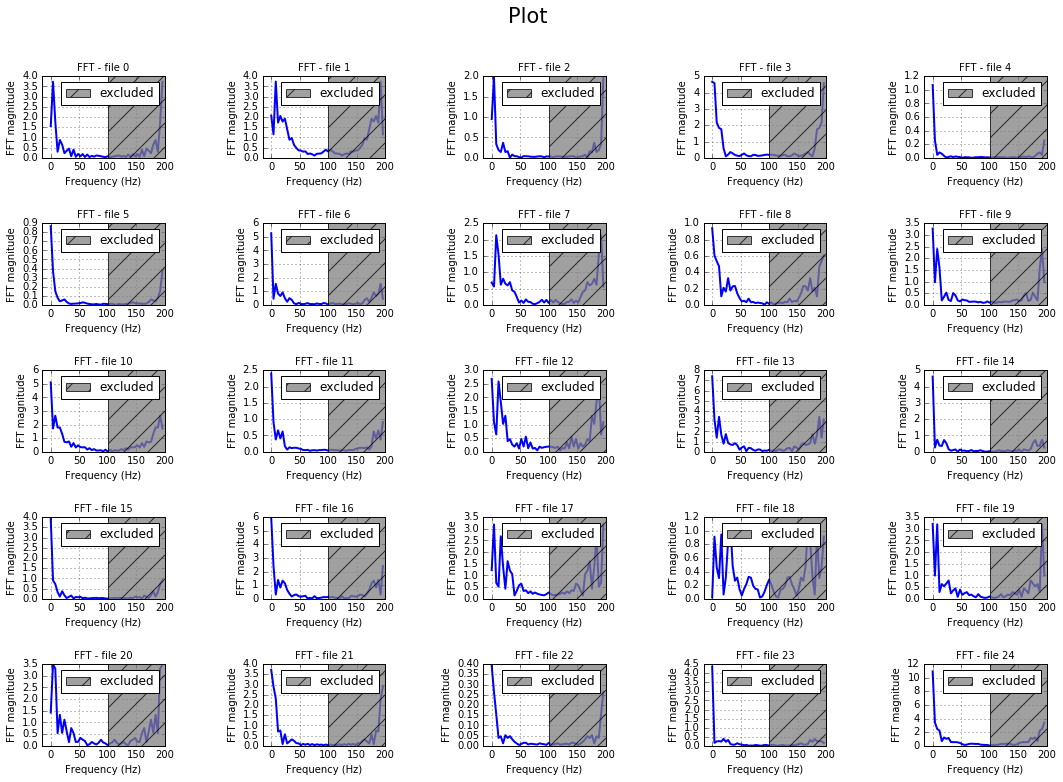

In [68]:
resX = gridOfFFT(signal_list[:50], 50, 'x')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


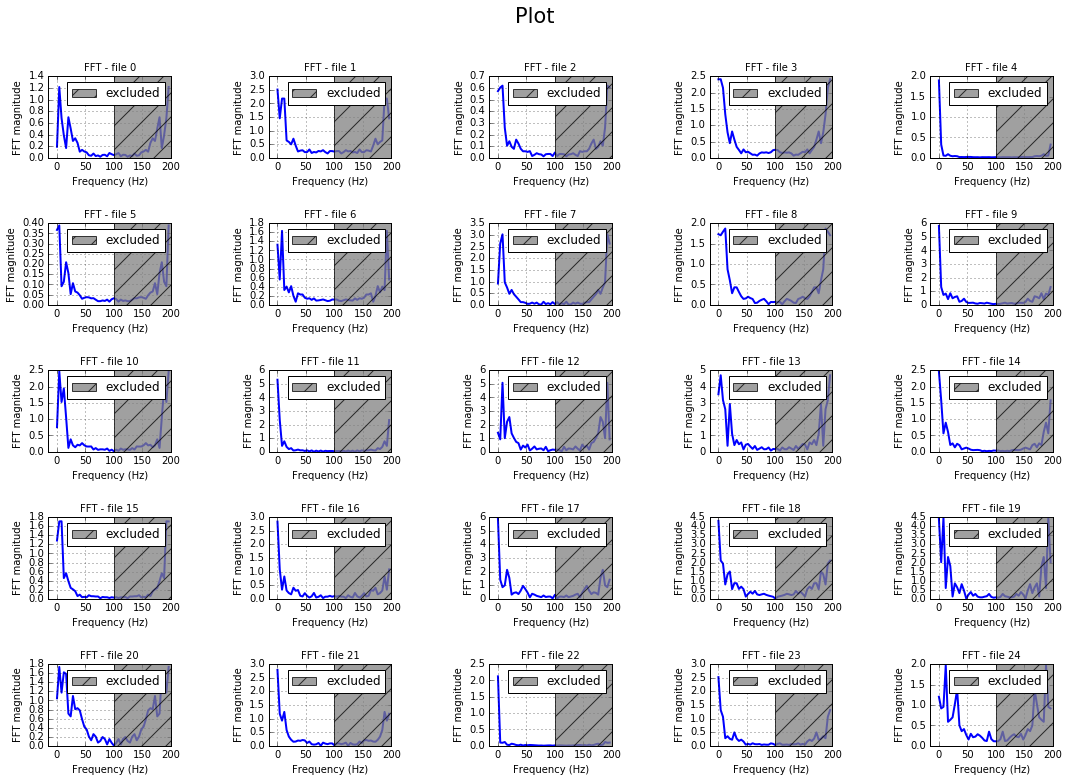

In [71]:
resY = gridOfFFT(signal_list[:50], 50, 'y')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


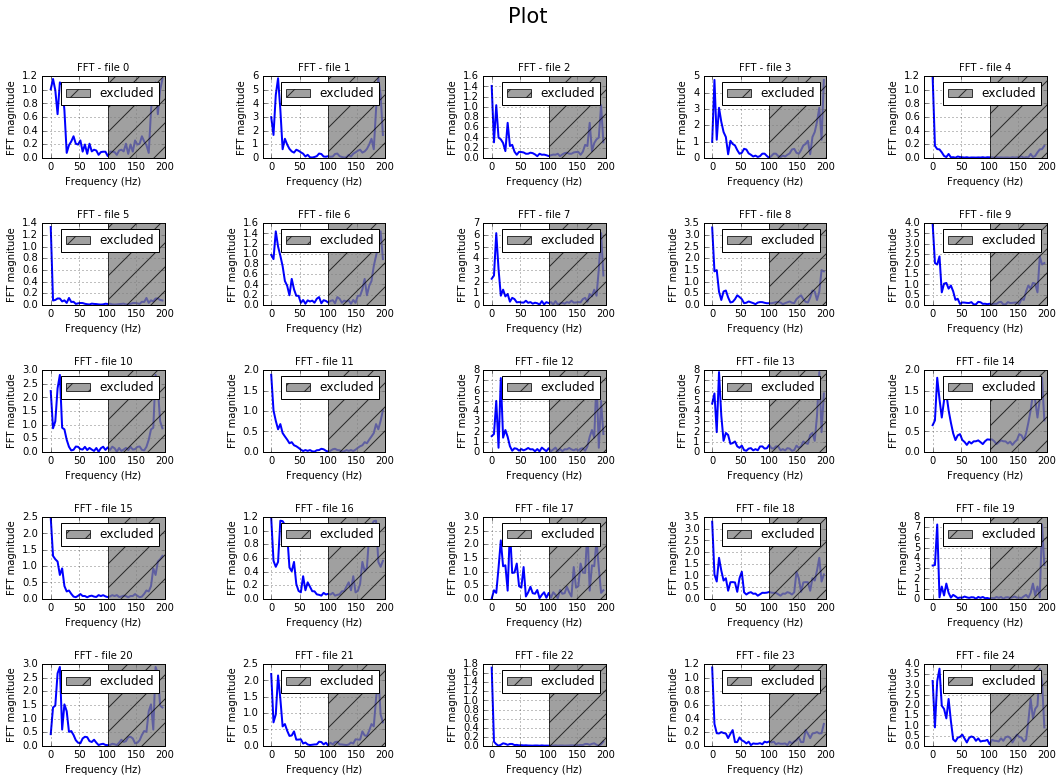

In [72]:
resZ = gridOfFFT(signal_list[:50], 50, 'z')

## Vectorize segments using metafeatures

In [ ]:
X = np.matrix(resX)
print X
print X.shape

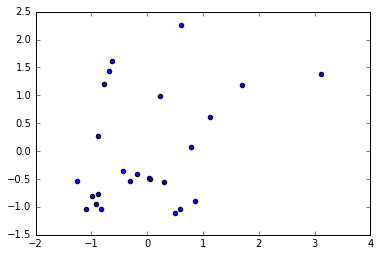

In [75]:
X_normed = (X - X.mean(axis=0)) / X.std(axis=0)
#print X_normed
X = X_normed
plt.scatter(X[:, 0],X[:, 1])

## Export data

In [22]:
writerX = csv.writer(open('acc_x.csv', 'w'))
writerY = csv.writer(open('acc_y.csv', 'w'))
writerZ = csv.writer(open('acc_z.csv', 'w'))

for i in range(len(signal_list)):
    if i != 0:
        break
    print len(signal_list[i]['x'])
    writerX.writerow(signal_list[i]['x'])
    writerY.writerow(signal_list[i]['y'])
    writerZ.writerow(signal_list[i]['z'])

1835


## Export to mat

In [33]:
name_to_save = './acc_x_2.mat'
print '-- Saving to: {}'.format(name_to_save)
data = signal_list[1]['x']
sio.savemat(name_to_save, {'x':data})
print

-- Saving to: ./acc_x_2.mat

